# Ideas

More options:

- Andere verdeling huizengroottes
- Pay as much as the second highest bidder
- Extra buyers and sellers based on data
- Andere locaties
- Base prices can change based on market data

More visualizations:

- Data on x-axis instead of month number
- Scenario analysis (run one agent and see what happens)
- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Histogram of house prices per time step (interactive?)
- Interactive dashboard to run one agent at the time?

## Imports

In [100]:
import mesa
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

## Data Loading

In [101]:
# data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
# the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df_interest = pd.read_csv('data_interest_rate.csv')
df_interest.drop([df_interest.index[120]], inplace=True)
df_interest.rename(columns={'Index': 'date'}, inplace=True)
display(df_interest.head())

df_inflation = pd.read_csv('inflation_data.csv')
df_inflation.drop([df_inflation.index[120]], inplace=True)
df_inflation.rename(columns={'observation_date': 'date',
                             'T10YIE': 'inflation_rate'}, inplace=True)
display(df_inflation.head())

,date,interest_rate
0,01/01/2013,0.084401
1,01/02/2013,0.172100
2,01/03/2013,0.050341
3,01/04/2013,-0.024212
4,01/05/2013,-0.019391


,date,inflation_rate
0,01/01/2013,2.52
1,01/02/2013,2.55
2,01/03/2013,2.54
3,01/04/2013,2.41
4,01/05/2013,2.28


## Classes

In [122]:
INTEREST_RATE_MONTHLY = 0.04 / 12
NUM_BUYERS = 10_000
NUM_HOUSES = 5_000

class Buyer(mesa.Agent):
    def __init__(self, model, salary: float, savings: float, age: float, dual_income: bool, preferred_location: str):
        super().__init__(model)
        self.salary = salary * 1.5 if dual_income else salary # assume dual_income increases salary by 50%
        self.savings = savings
        self.age = age
        self.dual_income = dual_income
        self.preferred_location = preferred_location
        self.budget = self.calculate_budget()
        
    def calculate_budget(self):
        mean_willing_to_pay_percentage = 1
        std_willing_to_pay_percentage = 0.1
        multiplier = np.random.normal(mean_willing_to_pay_percentage, std_willing_to_pay_percentage)
        # use age as a indicator of how much willing to pay and add some randomness
        willing_to_pay_percentage = (0.3 - (0.10 * (self.age - 20) / 40)) * multiplier
        
        payments = 360 # assume a 30 year morgage: 12 months * 30 years = 360
    
        down_payment_percentage = 0.20  # Assume 20% down payment
        down_payment = self.savings * down_payment_percentage

        max_monthly_payment = self.salary / 12 * willing_to_pay_percentage
        loan_amount = (max_monthly_payment * ((1 + INTEREST_RATE_MONTHLY)**payments - 1)) / \
                      (INTEREST_RATE_MONTHLY * (1 + INTEREST_RATE_MONTHLY)**payments)
        
        # Total budget is the loan amount plus the down payment
        total_budget = loan_amount + down_payment
        
        return total_budget

class House(mesa.Agent):
    def __init__(self, model, location: str, size: int):
        super().__init__(model)
        self.location = location
        self.size = size
        self.market_price = self.calculate_market_price()
    
    def calculate_market_price(self):
        # Base price per square unit (adjust based on location)
        base_price_per_sqm = {
        "urban": 5_000,
        "suburban": 3_000,
        "rural": 1_500,
        }[self.location]
    
        # Calculate the total price based on size
        price = base_price_per_sqm * self.size
        return price

class Market(mesa.Model):
    def __init__(self, num_buyers, num_houses):
        super().__init__()
        self.buyers = []
        self.houses = []
        self.sales = []
        self.time = 0
        self.buyer_counts = []
        self.house_counts = []
        self.sale_counts = []
        self.average_prices = []
        self.price_conf_intervals = []

        # Create initial buyers
        for _ in range(num_buyers):
            self.add_buyer()

        # Create initial houses
        for _ in range(num_houses):
            self.add_house()

    def add_buyer(self):
        mean_salary = 50_000 * (1.001 ** self.time) # realistic value
        std_dev_salary = 1000 * (1.001 ** self.time) # realistic value
        salary = np.clip(int(np.random.normal(mean_salary, std_dev_salary)), 20_000, 200_000)
        savings = self.random.uniform(0, 100_000) # add realistic savings
        age = self.random.randint(20, 60) # add realistic distribution
        dual_income = random.random() < 0.3  # 30% dual income households
        preferred_location = random.choices(["urban", "suburban", "rural"], weights=[0.5, 0.3, 0.2], k=1)[0]
        buyer = Buyer(self, salary, savings, age, dual_income, preferred_location)
        self.buyers.append(buyer)
        self.agents.add(buyer)

    def add_house(self):
        location = self.random.choices(["urban", "suburban", "rural"], weights= [0.5, 0.3, 0.2], k=1)[0]
        
        mean_size = 150
        std_dev_size = 50
        size = int(np.clip(np.random.normal(mean_size, std_dev_size), 50, 300))  
        
        house = House(self, location, size)
        self.houses.append(house)
        self.agents.add(house)
    
    def step(self):
        self.time += 1
        
        for _ in range(random.randint(0, int(NUM_BUYERS * 0.1))): self.add_buyer() # add realistic chances
        for _ in range (random.randint(0, int(NUM_HOUSES * 0.1))): self.add_house() # add realistic chances
        
        self.agents.shuffle_do('step')

        # Salaries increase slightly
        for buyer in self.buyers:
            buyer.salary *= 1.001  # add realistic number
            buyer.age += 0.08333 # 1/12 of a year
            buyer.savings += buyer.budget * 0.1  # Assume 10% of monthly money is saved

        self.market_model()
                
        self.buyer_counts.append(len(self.buyers))
        self.house_counts.append(len(self.houses))
        self.sale_counts.append(len(self.sales))
        
        # Calculate average house price and confidence interval
        if self.sales:
            prices = [list(sale.values())[0].budget for sale in self.sales]
            avg_price = np.mean(prices)
            conf_interval = 1.96 * np.std(prices) / np.sqrt(len(prices))
            self.average_prices.append(avg_price)
            self.price_conf_intervals.append(conf_interval)
        else:
            self.average_prices.append(0)
            self.price_conf_intervals.append(0)
    
    def market_model(self):
        # Group houses and buyers by location
        location_houses = defaultdict(list)
        for house in self.houses:
            location_houses[house.location].append(house)
        for loc in location_houses:
            location_houses[loc].sort(key=lambda x: -x.size)  # Sort by size (largest first)

        location_buyers = defaultdict(list)
        for buyer in self.buyers:
            location_buyers[buyer.preferred_location].append(buyer)
        for loc in location_buyers:
            location_buyers[loc].sort(key=lambda x: -x.budget)  # Sort by budget (highest first)

        # Process transactions
        sold_houses = []
        successful_buyers = []
        for loc in location_houses:
            houses = location_houses[loc]
            buyers = location_buyers[loc]
            for house in houses:
                if not buyers:
                    break  # No buyers left for this location
                
                # Find the highest bidder
                winning_buyer = buyers[0]
                
                # Check if the bid is acceptable (e.g., at least 80% of market price)
                if winning_buyer.budget >= 0.8 * house.market_price:
                    sold_houses.append(house)
                    successful_buyers.append(winning_buyer)
                    self.sales.append({house: winning_buyer})
                    # print(f"House in {house.location} (size={house.size}) sold to buyer aged {int(winning_buyer.age)} for ${int(winning_buyer.budget):,} (Market Price: ${int(house.market_price):,})")
                    buyers.pop(0)  # Remove the winning buyer
                # else:
                #     print(f"House in {house.location} (size={house.size}) not sold. Highest bid (${int(winning_buyer.budget):,}) was below 80% of market price (${int(house.market_price):,}).")

        # Remove transacted entities
        for house in sold_houses:
            self.houses.remove(house)
            self.agents.remove(house)
        for buyer in successful_buyers:
            self.buyers.remove(buyer)
            self.agents.remove(buyer)
    
    def visualize(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.time), self.buyer_counts, label="Total Buyers")
        plt.plot(range(self.time), self.house_counts, label="Total Houses")
        plt.plot(range(self.time), self.sale_counts, label="Total Sales")
        plt.title("Market Dynamics Over Time")
        plt.xlabel("Month")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.errorbar(range(self.time), self.average_prices, yerr=self.price_conf_intervals, 
                    fmt='-o', label="Average Price", ecolor='grey')
        plt.title("Home Price Trends with 95% Confidence Intervals")
        plt.xlabel("Month")
        plt.ylabel("Price ($)")
        plt.legend()
        
        plt.figure(figsize=(10, 5))
        prices_list = [list(sale.values())[0].budget for sale in self.sales]
        prices_list = [price for price in prices_list if price]
        plt.hist(prices_list, bins=20, alpha=0.7, color='blue', label='House Prices')
        plt.title("House Price Distribution per Step")
        plt.xlabel("Price ($)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
        
# Initialize the market with 10 buyers and 5 houses
market = Market(num_buyers=NUM_BUYERS, num_houses=NUM_HOUSES)

## Running the simulation

In [123]:
# Run the model for 10 steps and visualize the market state at each step
for _ in range(120):
    market.step()

## Visualisations

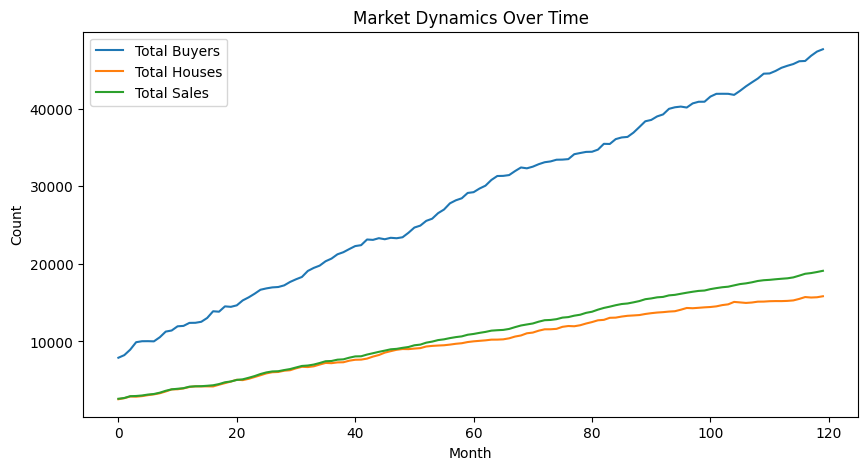

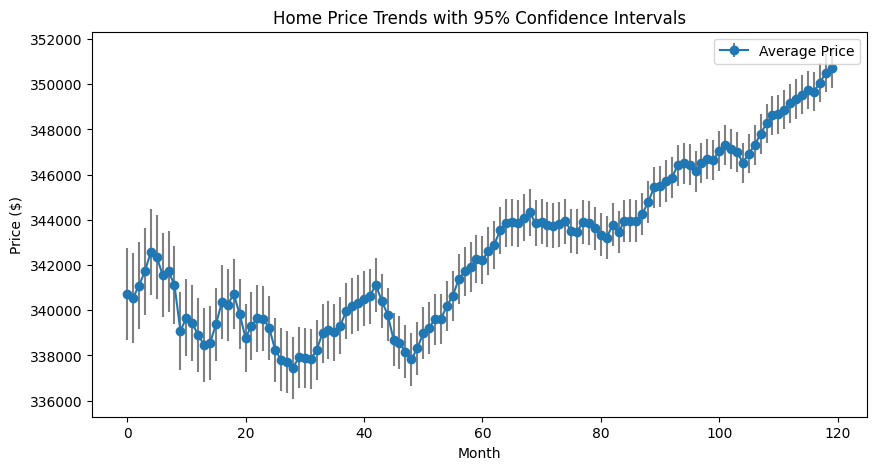

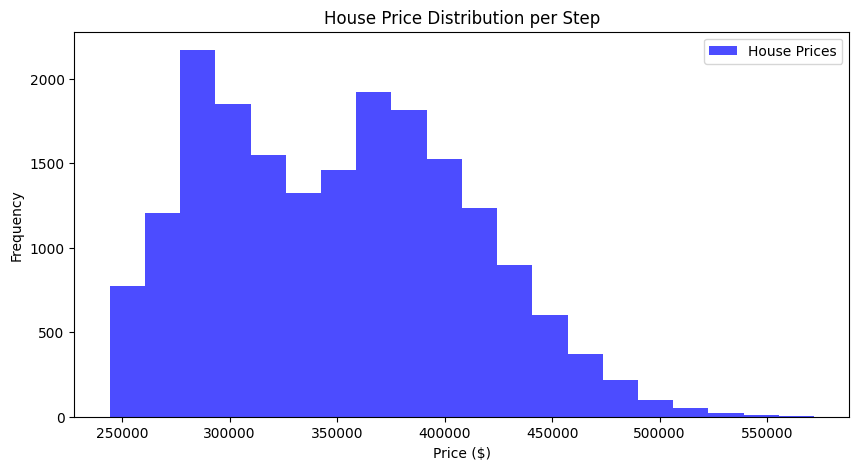

In [124]:
market.visualize()